<a href="https://colab.research.google.com/github/VISHALSARMAH/VISHALSARMAH/blob/main/Terrain%20Analysis%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# ==================================================================================================== #
#                                      SETUP FOR GOOGLE COLAB                                          #
# ==================================================================================================== #
# Install necessary libraries
!pip install timm torchmetrics -q

# Import libraries
import os
import torch
import shutil
import numpy as np
import random
import cv2

from glob import glob
from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms as T
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

import timm
import torchmetrics

# Set a random seed for reproducibility
torch.manual_seed(2024)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-2279192551.py:127: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cls_names, rotation=60)


Number of training batches: 90
Number of validation batches: 5
Number of test batches: 161
Class names: {'Desert': 0, 'Forest': 1, 'Mountain': 2, 'Plains': 3}
Class counts: {'Desert': 799, 'Forest': 799, 'Mountain': 799, 'Plains': 799}


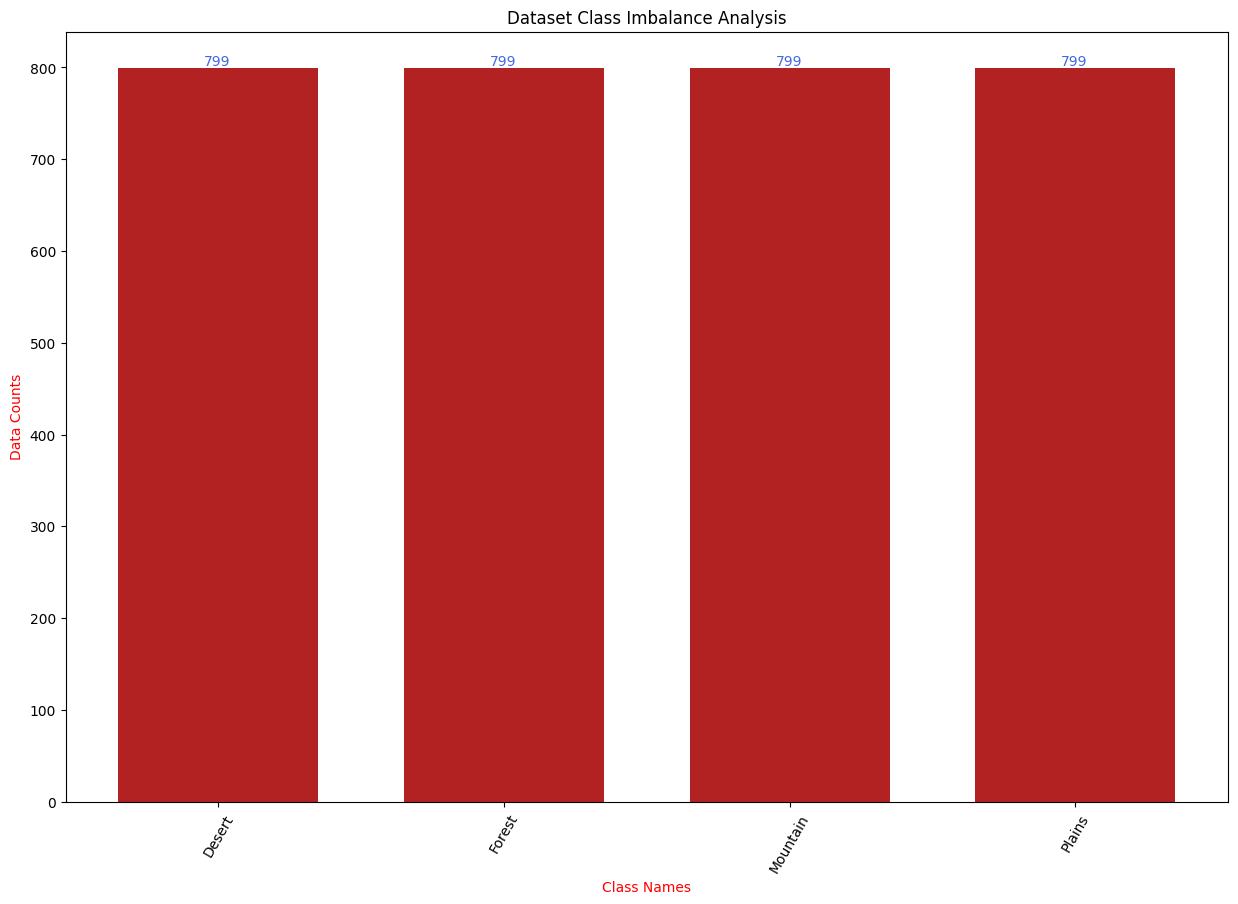

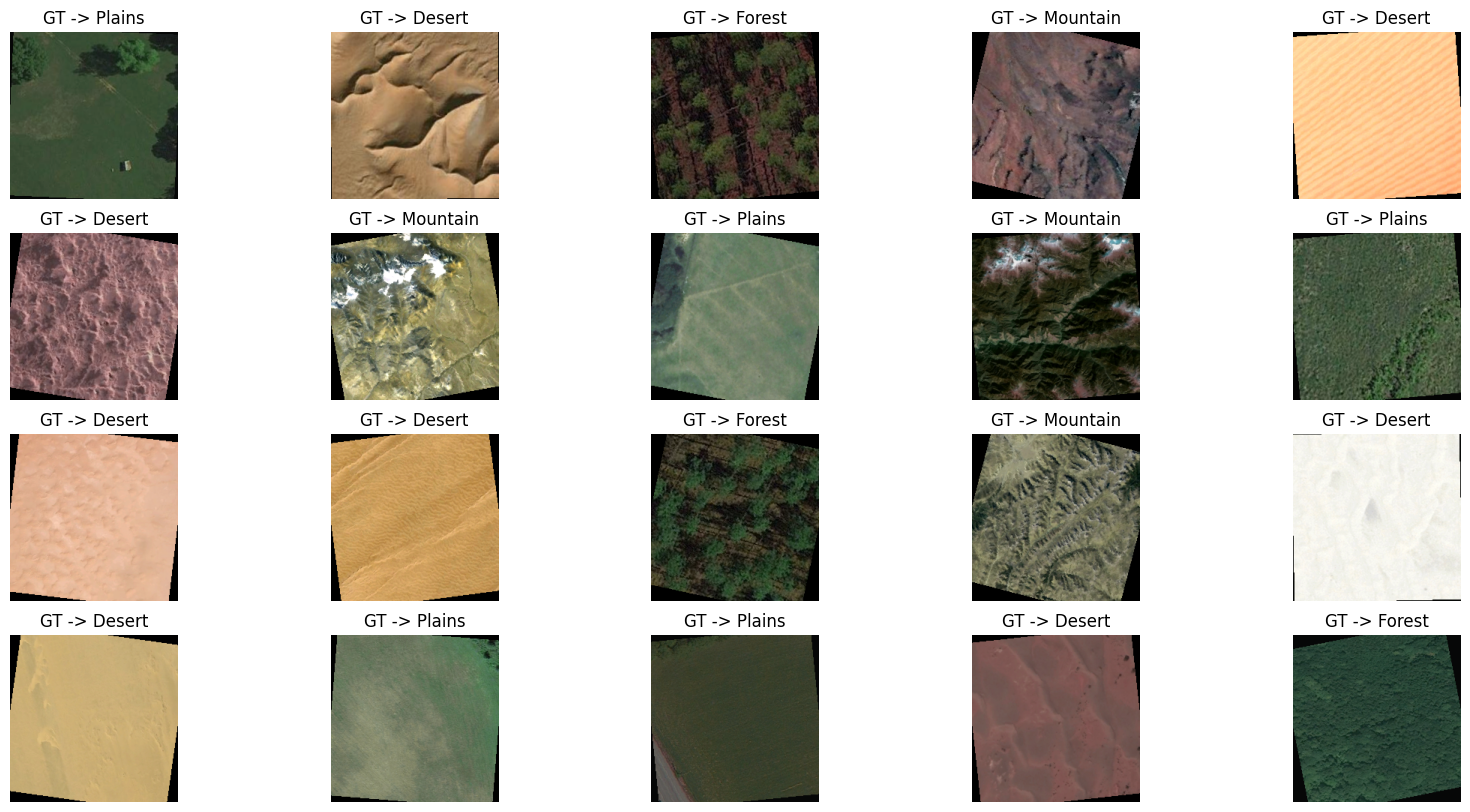

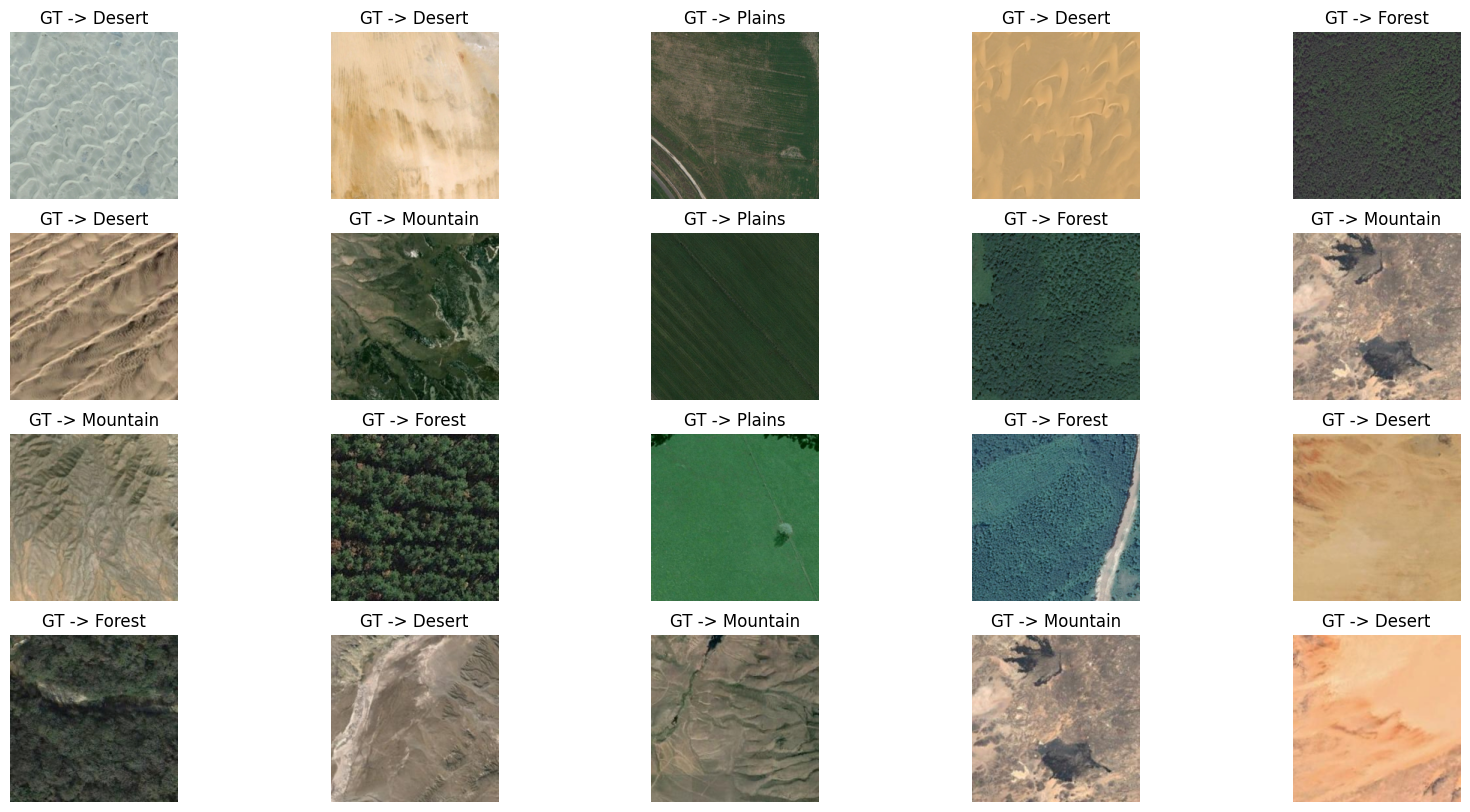

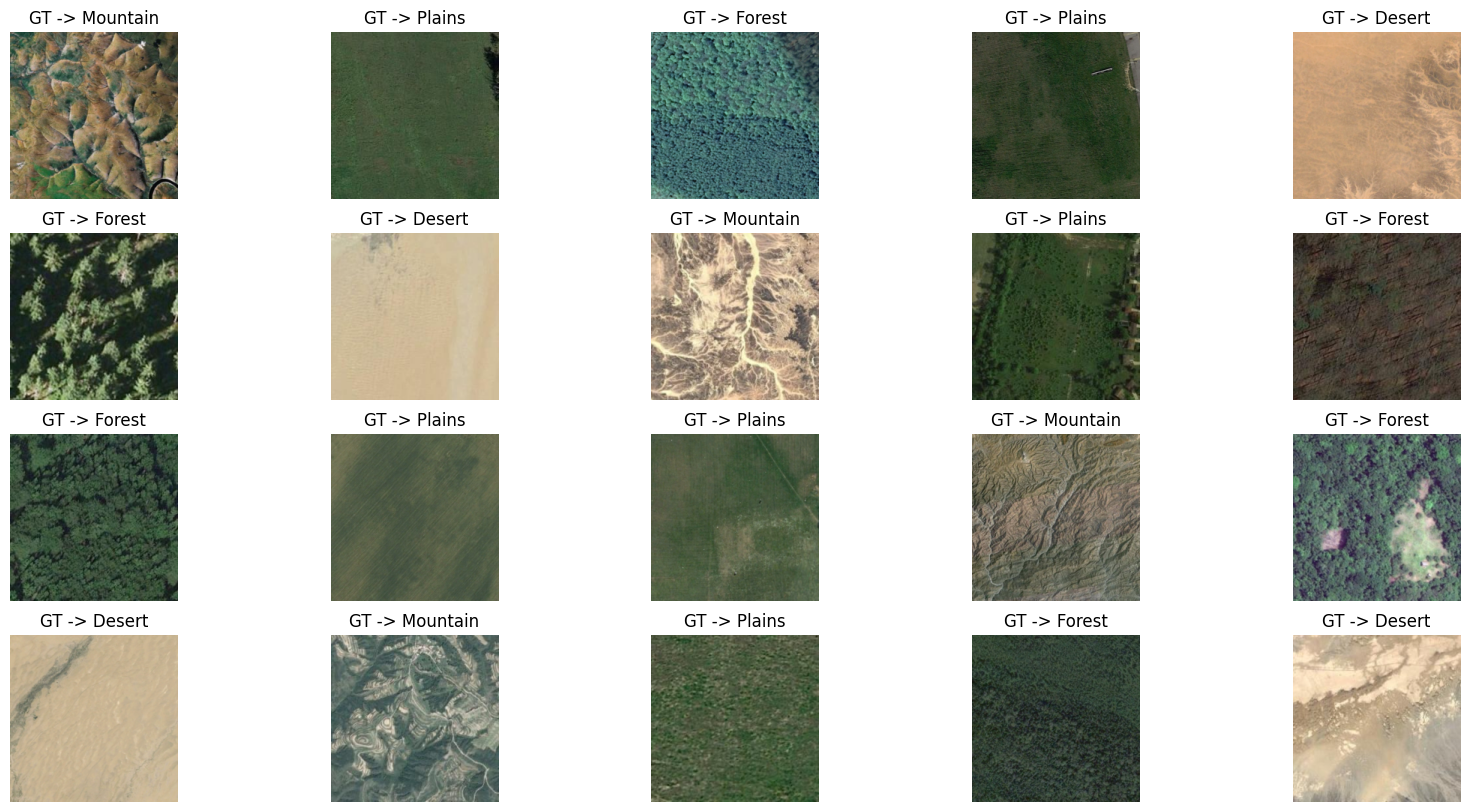

In [3]:

# ==================================================================================================== #
#                                          DATA PIPELINE                                               #
# ==================================================================================================== #

# If you need to unzip your dataset, use this block:
# from zipfile import ZipFile
# zip_path = '/content/SIH_NN.zip' # Change this to your zip file path
# with ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall('/content/')

# Make sure to set the root path to your dataset folder
# Example for a dataset located at `/content/dataset_folder`
root = "/content/drive/MyDrive/SIH_NN"

# Corrected CustomDataset class with proper dunder methods and file finding logic
class CustomDataset(Dataset):

    def __init__(self, root, transformations=None, im_files=[".jpg", ".jpeg", ".png"]):
        self.transformations = transformations

        im_paths = []
        for dirpath, _, filenames in os.walk(root):
            for filename in filenames:
                if any(filename.lower().endswith(ext) for ext in im_files):
                    im_paths.append(os.path.join(dirpath, filename))
        self.im_paths = sorted(im_paths)

        self.cls_names, self.cls_counts, count = {}, {}, 0
        for im_path in self.im_paths:
            class_name = self.get_class(im_path)
            if class_name not in self.cls_names:
                self.cls_names[class_name] = count
                self.cls_counts[class_name] = 1
                count += 1
            else:
                self.cls_counts[class_name] += 1

    def get_class(self, path):
        return os.path.basename(os.path.dirname(path))

    def __len__(self):
        return len(self.im_paths)

    def __getitem__(self, idx):
        im_path = self.im_paths[idx]
        im = Image.open(im_path).convert("RGB")
        gt = self.cls_names[self.get_class(im_path)]

        if self.transformations is not None:
            im = self.transformations(im)

        return im, gt

def get_dls(root, tr_tfs, val_tfs, bs, split=[0.9, 0.05, 0.05], ns=4):

    full_ds = CustomDataset(root=root)

    total_len = len(full_ds)
    tr_len = int(total_len * split[0])
    vl_len = int(total_len * split[1])
    ts_len = total_len - (tr_len + vl_len)

    # Split the dataset first, then apply transformations
    tr_ds_raw, vl_ds_raw, ts_ds_raw = random_split(
        dataset=full_ds,
        lengths=[tr_len, vl_len, ts_len]
    )

    # Create new datasets with the correct transformations
    tr_ds = CustomDataset(root=root, transformations=tr_tfs)
    tr_ds.im_paths = [full_ds.im_paths[i] for i in tr_ds_raw.indices]

    vl_ds = CustomDataset(root=root, transformations=val_tfs)
    vl_ds.im_paths = [full_ds.im_paths[i] for i in vl_ds_raw.indices]

    ts_ds = CustomDataset(root=root, transformations=val_tfs)
    ts_ds.im_paths = [full_ds.im_paths[i] for i in ts_ds_raw.indices]

    tr_dl = DataLoader(tr_ds, batch_size=bs, shuffle=True, num_workers=ns)
    val_dl = DataLoader(vl_ds, batch_size=bs, shuffle=False, num_workers=ns)
    ts_dl = DataLoader(ts_ds, batch_size=1, shuffle=False, num_workers=ns)

    return tr_dl, val_dl, ts_dl, full_ds.cls_names, full_ds.cls_counts

# Define transformations
im_size = 224
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

# Transformations with augmentation for the training set
tr_tfs = T.Compose([
    T.RandomResizedCrop(im_size, scale=(0.8, 1.0)),
    T.RandomRotation(15),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

# Transformations for validation and test sets (no augmentation)
val_tfs = T.Compose([
    T.Resize((im_size, im_size)),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

tr_dl, val_dl, ts_dl, classes, counts = get_dls(root=root, tr_tfs=tr_tfs, val_tfs=val_tfs, bs=32)

print(f"Number of training batches: {len(tr_dl)}")
print(f"Number of validation batches: {len(val_dl)}")
print(f"Number of test batches: {len(ts_dl)}")
print(f"Class names: {classes}")
print(f"Class counts: {counts}")

def data_analysis(root, transformations):

    ds = CustomDataset(root=root, transformations=transformations)
    cls_counts, width, text_width = ds.cls_counts, 0.7, 0.05
    text_height = 3
    cls_names = list(cls_counts.keys())
    counts = list(cls_counts.values())

    fig, ax = plt.subplots(figsize=(15, 10))
    indices = np.arange(len(counts))

    ax.bar(indices, counts, width, color="firebrick")
    ax.set_xlabel("Class Names", color="red")
    ax.set_xticklabels(cls_names, rotation=60)
    ax.set(xticks=indices, xticklabels=cls_names)
    ax.set_ylabel("Data Counts", color="red")
    ax.set_title(f"Dataset Class Imbalance Analysis")

    for i, v in enumerate(counts):
        ax.text(i - text_width, v + text_height, str(v), color="royalblue")

data_analysis(root=root, transformations=val_tfs)

def tensor_2_im(t, t_type="rgb"):

    gray_tfs = T.Compose([T.Normalize(mean=[0.], std=[1/0.5]), T.Normalize(mean=[-0.5], std=[1])])
    rgb_tfs = T.Compose([T.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]), T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.])])

    invTrans = gray_tfs if t_type == "gray" else rgb_tfs

    if t_type == "gray":
        return (invTrans(t) * 255).detach().squeeze().cpu().permute(1, 2, 0).numpy().astype(np.uint8)
    else:
        return (invTrans(t) * 255).detach().cpu().permute(1, 2, 0).numpy().astype(np.uint8)

def visualize(data, n_ims, rows, cmap=None, cls_names=None):

    assert cmap in ["rgb", "gray"], "Rasmni oq-qora yoki rangli ekanini aniqlashtirib bering!"
    if cmap == "rgb":
        cmap = "viridis"

    plt.figure(figsize=(20, 10))
    indekslar = [random.randint(0, len(data) - 1) for _ in range(n_ims)]

    for idx, indeks in enumerate(indekslar):

        im, gt = data[indeks]
        # Start plot
        plt.subplot(rows, n_ims // rows, idx + 1)
        if cmap:
            plt.imshow(tensor_2_im(im, cmap), cmap=cmap)
        else:
            plt.imshow(tensor_2_im(im))
        plt.axis('off')
        if cls_names is not None:
            plt.title(f"GT -> {cls_names[int(gt)]}")
        else:
            plt.title(f"GT -> {gt}")

visualize(tr_dl.dataset, 20, 4, "rgb", list(classes.keys()))
visualize(val_dl.dataset, 20, 4, "rgb", list(classes.keys()))
visualize(ts_dl.dataset, 20, 4, "rgb", list(classes.keys()))


In [4]:

# ==================================================================================================== #
#                                           MODEL TRAINING                                             #
# ==================================================================================================== #

m = timm.create_model("rexnet_200", pretrained=True, num_classes=len(classes))

def train_setup(m):
    return m.to("cuda").eval(), 10, "cuda", torch.nn.CrossEntropyLoss(), torch.optim.Adam(params=m.parameters(), lr=3e-4)

def to_device(batch, device):
    return batch[0].to(device), batch[1].to(device)

def get_metrics(model, ims, gts, loss_fn, epoch_loss, epoch_acc, epoch_f1):
    preds = model(ims)
    loss = loss_fn(preds, gts)
    return loss, epoch_loss + (loss.item()), epoch_acc + (torch.argmax(preds, dim=1) == gts).sum().item(), epoch_f1 + f1_score(preds, gts)

m, epochs, device, loss_fn, optimizer = train_setup(m)

f1_score = torchmetrics.F1Score(task="multiclass", num_classes=len(classes)).to(device)
save_prefix, save_dir = "terrain", "saved_models"
print("Start training...")
best_acc, best_loss, threshold, not_improved, patience = 0, float("inf"), 0.01, 0, 5

# Initialize lists to store metrics - THIS IS THE FIX
tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s = [], [], [], [], [], []

best_loss = float(torch.inf)

for epoch in range(epochs):

    m.train()
    epoch_loss, epoch_acc, epoch_f1 = 0, 0, 0
    for idx, batch in tqdm(enumerate(tr_dl), desc=f"Epoch {epoch+1}/{epochs} (Training)", total=len(tr_dl)):
        ims, gts = to_device(batch, device)
        loss, epoch_loss, epoch_acc, epoch_f1 = get_metrics(m, ims, gts, loss_fn, epoch_loss, epoch_acc, epoch_f1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    tr_loss_to_track = epoch_loss / len(tr_dl)
    tr_acc_to_track = epoch_acc / len(tr_dl.dataset)
    tr_f1_to_track = epoch_f1 / len(tr_dl)
    tr_losses.append(tr_loss_to_track)
    tr_accs.append(tr_acc_to_track)
    tr_f1s.append(tr_f1_to_track)

    print(f"{epoch + 1}-epoch train process is completed!")
    print(f"  Train Loss: {tr_loss_to_track:.3f}")
    print(f"  Train Accuracy: {tr_acc_to_track:.3f}")
    print(f"  Train F1-Score: {tr_f1_to_track:.3f}")

    m.eval()
    with torch.no_grad():
        val_epoch_loss, val_epoch_acc, val_epoch_f1 = 0, 0, 0
        for idx, batch in tqdm(enumerate(val_dl), desc=f"Epoch {epoch+1}/{epochs} (Validation)", total=len(val_dl)):
            ims, gts = to_device(batch, device)
            loss, val_epoch_loss, val_epoch_acc, val_epoch_f1 = get_metrics(m, ims, gts, loss_fn, val_epoch_loss, val_epoch_acc, val_epoch_f1)

        val_loss_to_track = val_epoch_loss / len(val_dl)
        val_acc_to_track = val_epoch_acc / len(val_dl.dataset)
        val_f1_to_track = val_epoch_f1 / len(val_dl)
        val_losses.append(val_loss_to_track)
        val_accs.append(val_acc_to_track)
        val_f1s.append(val_f1_to_track)

        print(f"{epoch + 1}-epoch validation process is completed!")
        print(f"  Validation Loss: {val_loss_to_track:.3f}")
        print(f"  Validation Accuracy: {val_acc_to_track:.3f}")
        print(f"  Validation F1-Score: {val_f1_to_track:.3f}")

        if val_loss_to_track < (best_loss + threshold):
            os.makedirs(save_dir, exist_ok=True)
            best_loss = val_loss_to_track
            torch.save(m.state_dict(), f"{save_dir}/{save_prefix}_best_model.pth")
        else:
            not_improved += 1
            print(f"Loss value did not decrease for {not_improved} epochs")
            if not_improved == patience:
                print(f"Stop training since loss value did not decrease for {patience} epochs.")
                break


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/65.8M [00:00<?, ?B/s]

Start training...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/10 (Training):   0%|          | 0/90 [00:00<?, ?it/s]

1-epoch train process is completed!
  Train Loss: 0.496
  Train Accuracy: 0.896
  Train F1-Score: 0.897


Epoch 1/10 (Validation):   0%|          | 0/5 [00:00<?, ?it/s]

1-epoch validation process is completed!
  Validation Loss: 0.158
  Validation Accuracy: 0.969
  Validation F1-Score: 0.969


Epoch 2/10 (Training):   0%|          | 0/90 [00:00<?, ?it/s]

2-epoch train process is completed!
  Train Loss: 0.192
  Train Accuracy: 0.957
  Train F1-Score: 0.957


Epoch 2/10 (Validation):   0%|          | 0/5 [00:00<?, ?it/s]

2-epoch validation process is completed!
  Validation Loss: 0.113
  Validation Accuracy: 0.962
  Validation F1-Score: 0.962


Epoch 3/10 (Training):   0%|          | 0/90 [00:00<?, ?it/s]

3-epoch train process is completed!
  Train Loss: 0.167
  Train Accuracy: 0.961
  Train F1-Score: 0.961


Epoch 3/10 (Validation):   0%|          | 0/5 [00:00<?, ?it/s]

3-epoch validation process is completed!
  Validation Loss: 0.224
  Validation Accuracy: 0.943
  Validation F1-Score: 0.944
Loss value did not decrease for 1 epochs


Epoch 4/10 (Training):   0%|          | 0/90 [00:00<?, ?it/s]

4-epoch train process is completed!
  Train Loss: 0.111
  Train Accuracy: 0.969
  Train F1-Score: 0.969


Epoch 4/10 (Validation):   0%|          | 0/5 [00:00<?, ?it/s]

4-epoch validation process is completed!
  Validation Loss: 0.123
  Validation Accuracy: 0.962
  Validation F1-Score: 0.962


Epoch 5/10 (Training):   0%|          | 0/90 [00:00<?, ?it/s]

5-epoch train process is completed!
  Train Loss: 0.094
  Train Accuracy: 0.973
  Train F1-Score: 0.973


Epoch 5/10 (Validation):   0%|          | 0/5 [00:00<?, ?it/s]

5-epoch validation process is completed!
  Validation Loss: 0.037
  Validation Accuracy: 0.994
  Validation F1-Score: 0.994


Epoch 6/10 (Training):   0%|          | 0/90 [00:00<?, ?it/s]

6-epoch train process is completed!
  Train Loss: 0.091
  Train Accuracy: 0.974
  Train F1-Score: 0.974


Epoch 6/10 (Validation):   0%|          | 0/5 [00:00<?, ?it/s]

6-epoch validation process is completed!
  Validation Loss: 0.146
  Validation Accuracy: 0.962
  Validation F1-Score: 0.962
Loss value did not decrease for 2 epochs


Epoch 7/10 (Training):   0%|          | 0/90 [00:00<?, ?it/s]

7-epoch train process is completed!
  Train Loss: 0.048
  Train Accuracy: 0.983
  Train F1-Score: 0.983


Epoch 7/10 (Validation):   0%|          | 0/5 [00:00<?, ?it/s]

7-epoch validation process is completed!
  Validation Loss: 0.101
  Validation Accuracy: 0.962
  Validation F1-Score: 0.962
Loss value did not decrease for 3 epochs


Epoch 8/10 (Training):   0%|          | 0/90 [00:00<?, ?it/s]

8-epoch train process is completed!
  Train Loss: 0.066
  Train Accuracy: 0.983
  Train F1-Score: 0.983


Epoch 8/10 (Validation):   0%|          | 0/5 [00:00<?, ?it/s]

8-epoch validation process is completed!
  Validation Loss: 0.026
  Validation Accuracy: 0.987
  Validation F1-Score: 0.987


Epoch 9/10 (Training):   0%|          | 0/90 [00:00<?, ?it/s]

9-epoch train process is completed!
  Train Loss: 0.047
  Train Accuracy: 0.987
  Train F1-Score: 0.988


Epoch 9/10 (Validation):   0%|          | 0/5 [00:00<?, ?it/s]

9-epoch validation process is completed!
  Validation Loss: 0.075
  Validation Accuracy: 0.975
  Validation F1-Score: 0.975
Loss value did not decrease for 4 epochs


Epoch 10/10 (Training):   0%|          | 0/90 [00:00<?, ?it/s]

10-epoch train process is completed!
  Train Loss: 0.073
  Train Accuracy: 0.982
  Train F1-Score: 0.982


Epoch 10/10 (Validation):   0%|          | 0/5 [00:00<?, ?it/s]

10-epoch validation process is completed!
  Validation Loss: 0.108
  Validation Accuracy: 0.969
  Validation F1-Score: 0.968
Loss value did not decrease for 5 epochs
Stop training since loss value did not decrease for 5 epochs.


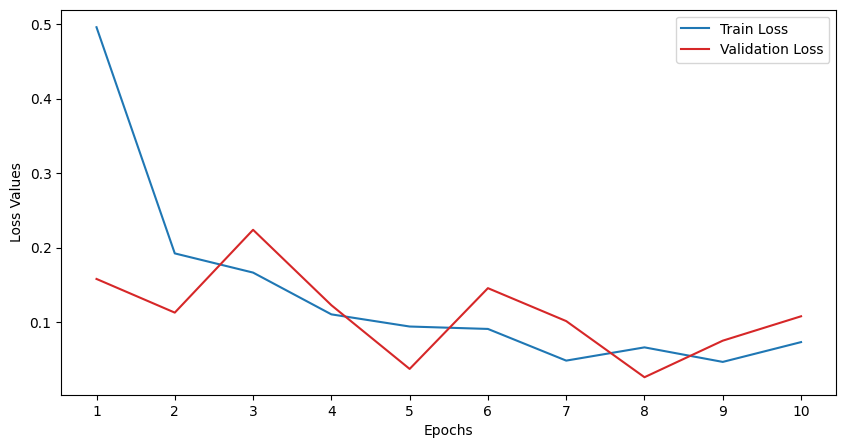

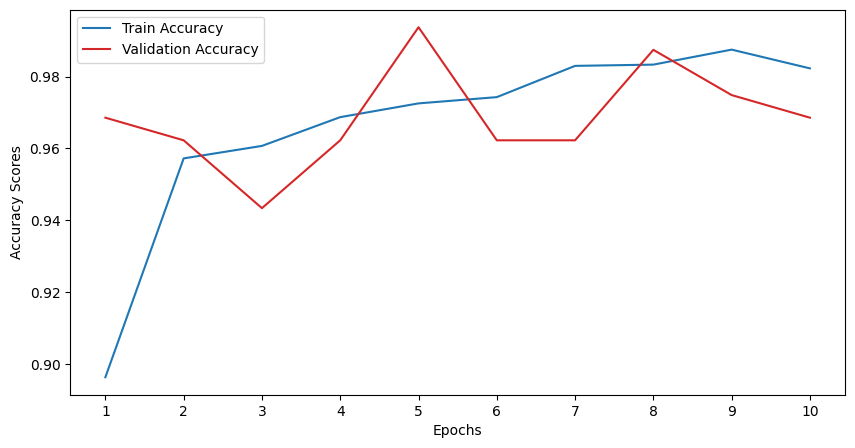

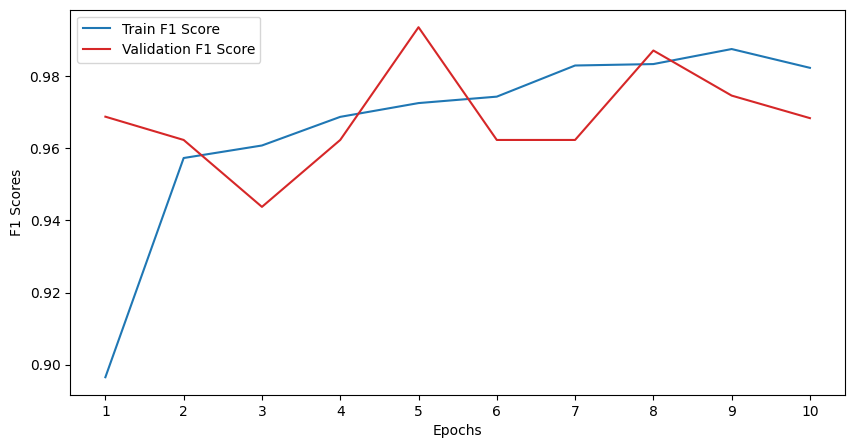

In [5]:

# ==================================================================================================== #
#                                           VISUALIZATION                                              #
# ==================================================================================================== #

class PlotLearningCurves:

    def __init__(self, tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s):
        self.tr_losses, self.val_losses = tr_losses, val_losses
        self.tr_accs, self.val_accs = tr_accs, val_accs
        self.tr_f1s, self.val_f1s = tr_f1s, val_f1s

    def plot(self, array_1, array_2, label_1, label_2, color_1, color_2):
        plt.plot(array_1, label=label_1, c=color_1)
        plt.plot(array_2, label=label_2, c=color_2)

    def create_figure(self):
        plt.figure(figsize=(10, 5))

    def decorate(self, ylabel, xlabel="Epochs"):
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xticks(ticks=np.arange(len(self.tr_accs)), labels=[i for i in range(1, len(self.tr_accs) + 1)])
        plt.legend()
        plt.show()

    def visualize(self):
        self.create_figure()
        self.plot(array_1=self.tr_losses, array_2=self.val_losses, label_1="Train Loss", label_2="Validation Loss", color_1="tab:blue", color_2="tab:red")
        self.decorate(ylabel="Loss Values")

        self.create_figure()
        self.plot(array_1=self.tr_accs, array_2=self.val_accs, label_1="Train Accuracy", label_2="Validation Accuracy", color_1="tab:blue", color_2="tab:red")
        self.decorate(ylabel="Accuracy Scores")

        self.create_figure()
        self.plot(array_1=[tr_f1.cpu() for tr_f1 in self.tr_f1s], array_2=[vl_f1.cpu() for vl_f1 in self.val_f1s], label_1="Train F1 Score", label_2="Validation F1 Score", color_1="tab:blue", color_2="tab:red")
        self.decorate(ylabel="F1 Scores")

PlotLearningCurves(tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s).visualize()


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Inference:   0%|          | 0/161 [00:00<?, ?it/s]


Accuracy of the model on the test data -> 0.975

=== Terrain Coverage (% per class) ===
Desert: 23.60%
Forest: 24.22%
Mountain: 27.33%
Plains: 24.84%
Number of uncertain patches (confidence < 0.6): 0


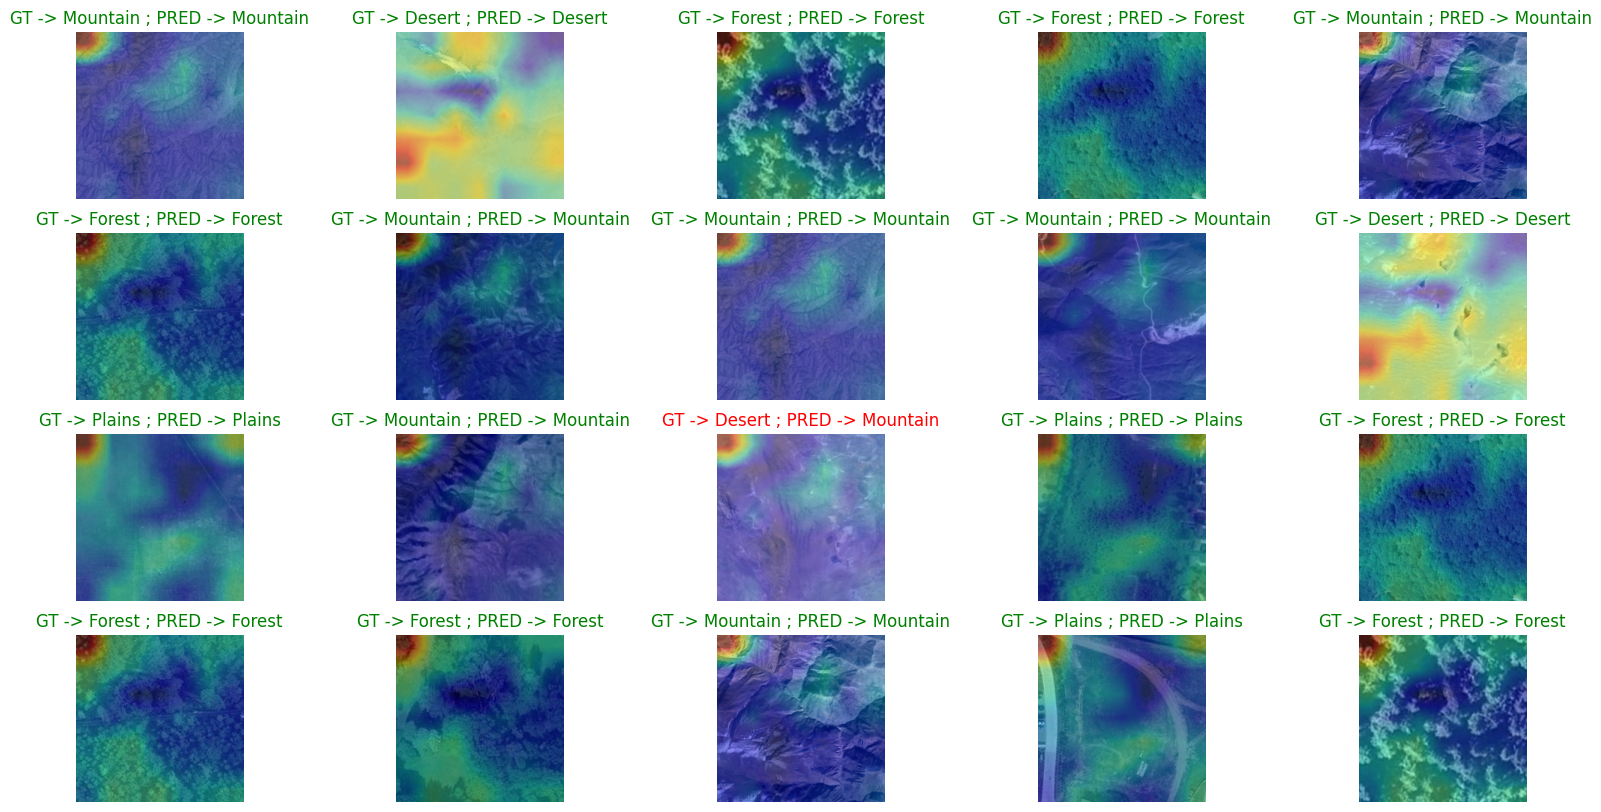

In [6]:
# ==================================================================================================== #
#                               INFERENCE + TERRAIN ANALYSIS + CAM VISUALIZATION                       #
# ==================================================================================================== #

class SaveFeatures():
    """ Extract pretrained activations """
    features = None
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()
    def remove(self):
        self.hook.remove()

def getCAM(conv_fs, linear_weights, class_idx):
    bs, chs, h, w = conv_fs.shape
    cam = linear_weights[class_idx].dot(conv_fs[0, :, :, ].reshape((chs, h * w)))
    cam = cam.reshape(h, w)
    return (cam - np.min(cam)) / np.max(cam)

def terrain_analysis(preds, cls_names, probs_list=None, threshold=0.6):
    from collections import Counter
    total_patches = len(preds)
    terrain_counts = Counter(preds)
    coverage = {cls_names[k]: v/total_patches*100 for k,v in terrain_counts.items()}

    print("\n=== Terrain Coverage (% per class) ===")
    for terrain, perc in coverage.items():
        print(f"{terrain}: {perc:.2f}%")

    if probs_list is not None:
        # Count low-confidence predictions
        uncertain = sum((torch.max(p).item() < threshold) for p in probs_list)
        print(f"Number of uncertain patches (confidence < {threshold}): {uncertain}")

def inference(model, device, test_dl, num_ims, row, final_conv, fc_params, cls_names=None, analyze=True):
    weight, acc = np.squeeze(fc_params[0].cpu().data.numpy()), 0
    activated_features = SaveFeatures(final_conv)

    preds, images, lbls, probs_list = [], [], [], []

    for idx, batch in tqdm(enumerate(test_dl), desc="Inference", total=len(test_dl)):
        im, gt = to_device(batch, device)
        output = model(im)
        pred_class = torch.argmax(output, dim=1)
        acc += (pred_class == gt).sum().item()

        # Store for analysis
        preds.append(pred_class.item())
        lbls.append(gt.item())
        images.append(im)
        probs_list.append(output.detach().cpu())

    print(f"\nAccuracy of the model on the test data -> {(acc / len(test_dl.dataset)):.3f}")

    # Terrain Analysis
    if analyze:
        terrain_analysis(preds, cls_names, probs_list)

    # CAM Visualization
    plt.figure(figsize=(20, 10))
    indices = [random.randint(0, len(images) - 1) for _ in range(num_ims)]

    for idx, ind in enumerate(indices):
        im = images[ind].squeeze()
        pred_idx = preds[ind]
        heatmap = getCAM(activated_features.features, weight, pred_idx)

        plt.subplot(row, num_ims // row, idx + 1)
        plt.imshow(tensor_2_im(im), cmap="gray")
        plt.axis("off")
        plt.imshow(cv2.resize(heatmap, (im_size, im_size), interpolation=cv2.INTER_LINEAR), alpha=0.4, cmap='jet')
        plt.axis("off")

        if cls_names is not None:
            plt.title(f"GT -> {cls_names[int(lbls[ind])]} ; PRED -> {cls_names[int(preds[ind])]}",
                      color=("green" if cls_names[int(lbls[ind])] == cls_names[int(preds[ind])] else "red"))
        else:
            plt.title(f"GT -> {gt} ; PRED -> {pred_class}")

# Load model and run inference
m.load_state_dict(torch.load(f"{save_dir}/{save_prefix}_best_model.pth"))
m.eval()
final_conv, fc_params = m.features[-1], list(m.head.fc.parameters())

inference(
    model=m.to(device),
    device=device,
    test_dl=ts_dl,
    num_ims=20,
    row=4,
    cls_names=list(classes.keys()),
    final_conv=final_conv,
    fc_params=fc_params,
    analyze=True
)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


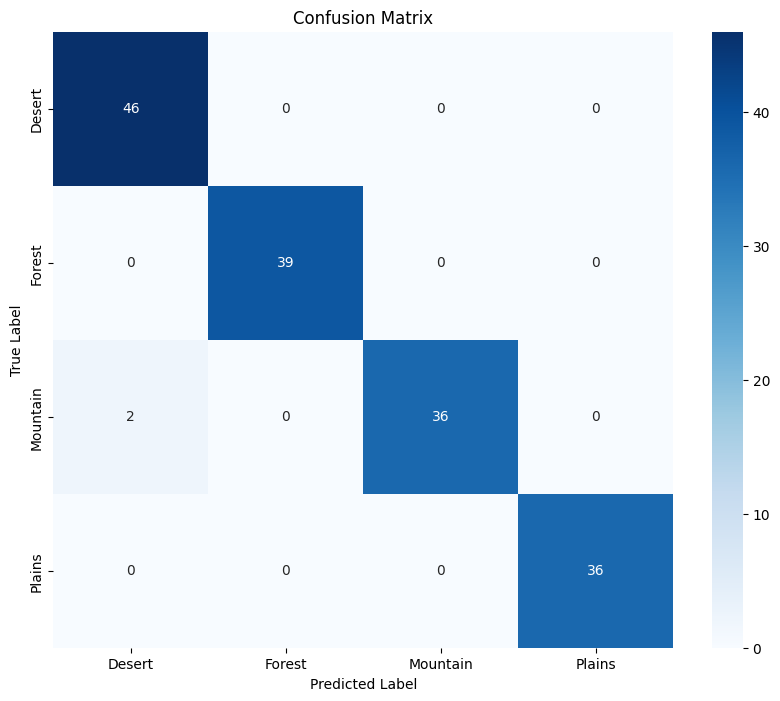

Classification Report:
              precision    recall  f1-score   support

      Desert       0.96      1.00      0.98        46
      Forest       1.00      1.00      1.00        39
    Mountain       1.00      0.95      0.97        38
      Plains       1.00      1.00      1.00        36

    accuracy                           0.99       159
   macro avg       0.99      0.99      0.99       159
weighted avg       0.99      0.99      0.99       159



In [7]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_and_plot_metrics(model, dataloader, device, classes):
    """
    Evaluates the model and prints the confusion matrix and classification report.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Generate Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Generate and print the Classification Report (includes F1 score)
    report = classification_report(all_labels, all_preds, target_names=classes)
    print("Classification Report:")
    print(report)

# After your training loop is complete, call the function
# Replace `ts_dl` with the dataloader you want to evaluate (e.g., `val_dl` or `ts_dl`)
# Replace `m` with your trained model
# Replace `device` and `classes` with your variables
evaluate_and_plot_metrics(model=m, dataloader=val_dl, device=device, classes=list(classes.keys()))

In [21]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def evaluate_and_plot_metrics(model, dataloader, device, classes):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f"Collected {len(all_labels)} labels and {len(all_preds)} predictions")

    # ✅ Ensure we have predictions
    if len(all_labels) == 0:
        print("⚠️ No samples were collected. Check dataloader or model output.")
        return

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Normalized Confusion Matrix
    cm_norm = confusion_matrix(all_labels, all_preds, normalize="true")
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.title("Normalized Confusion Matrix (%)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))

    # ✅ Per-Class Accuracy
    print("\n=== Per-Class Accuracy ===")
    for i, cls in enumerate(classes):
        cls_idx = [j for j, lbl in enumerate(all_labels) if lbl == i]
        if cls_idx:
            acc = accuracy_score([all_labels[j] for j in cls_idx],
                                 [all_preds[j] for j in cls_idx])
            print(f"{cls}: {acc:.3f}")
        else:
            print(f"{cls}: No samples in this split")


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Collected 159 labels and 159 predictions


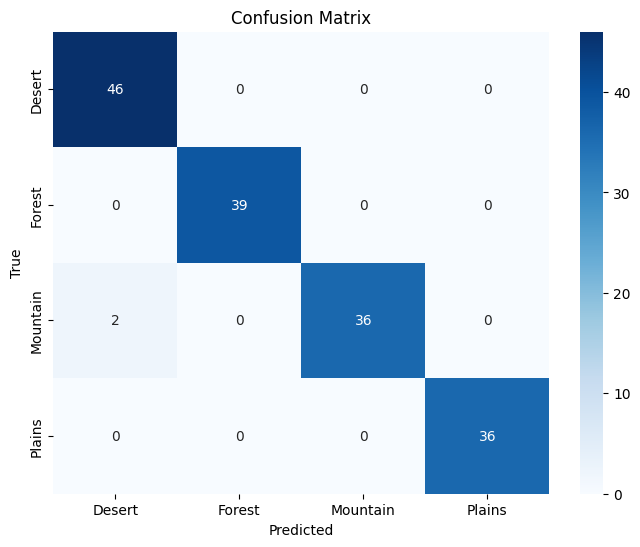

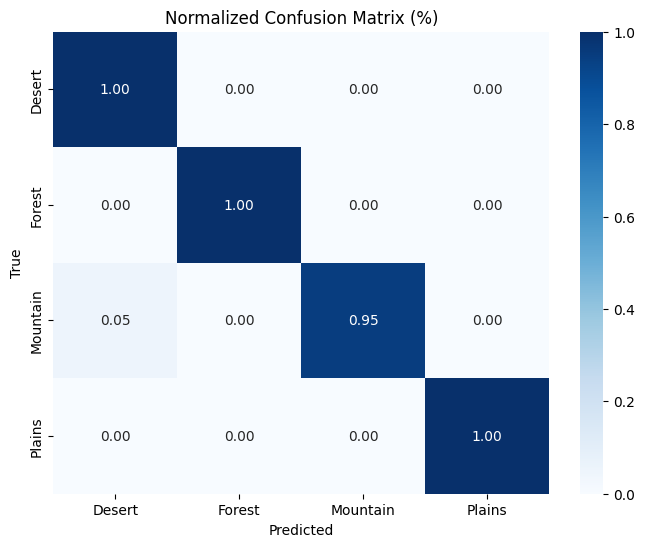


Classification Report:
              precision    recall  f1-score   support

      Desert       0.96      1.00      0.98        46
      Forest       1.00      1.00      1.00        39
    Mountain       1.00      0.95      0.97        38
      Plains       1.00      1.00      1.00        36

    accuracy                           0.99       159
   macro avg       0.99      0.99      0.99       159
weighted avg       0.99      0.99      0.99       159


=== Per-Class Accuracy ===
Desert: 1.000
Forest: 1.000
Mountain: 0.947
Plains: 1.000


In [22]:
evaluate_and_plot_metrics(model=m, dataloader=val_dl, device=device, classes=list(classes.keys()))
